# Plotting Covid-19 data from Belgium

Source of data: [RTBF](https://www.rtbf.be/info/societe/detail_coronavirus-en-belgique-les-chiffres-du-nombre-de-personnes-hospitalisees-infographie?id=10458755). Last update 31/03.

Source for 01/04: [RTBF](https://www.rtbf.be/info/belgique/detail_coronavirus-en-belgique-suivez-en-direct-le-bilan-quotidien-du-centre-de-crise?id=10472832)

This is not (data) science, it's just a plot of some data and a linear regression.

License [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
%pylab inline
import pandas as pd
from datetime import date, timedelta

import matplotlib
matplotlib.rc('figure', figsize=(17, 8))

from scipy.optimize import curve_fit
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
start = date(2020, 3, 14)
df = pd.DataFrame([
    (97, 24, 22),
    (163, 33, 23),
    (252, 53, 31),
    (361, 79, 51),
    (496, 100, 66),
    (634, 130, 88),
    (837, 164, 114),
    (1089, 238, 167),
    (1380, 290, None),
    (1643, 322, None),
    (1859, 381, 242),
    (2152, 433, 322),
    (2652, 605, 420),
    (3042, 690, 498),
    (3717, 789, 579),
    (4138, 867, 656),
    (4524, 927, 696),
    (4920, 1021, 786),
    (4995, 1088, 834),
    (5376, 1144, 906),
], columns=["hospit", "intensif", "respi"])

gvt_measures = [
    pd.to_datetime('2020-03-14'),  # Bars and non-essential shops closed
    pd.to_datetime('2020-03-17'),  # Lockdown
]

df['date'] = pd.Series(df.index).apply(lambda x: start + timedelta(days=x))
df['day'] = pd.Series(df.index) + 1
df = df.set_index("date")

In [3]:
df.head()

,hospit,intensif,respi,day
date,,,,
2020-03-14,97,24,22.0,1
2020-03-15,163,33,23.0,2
2020-03-16,252,53,31.0,3
2020-03-17,361,79,51.0,4
2020-03-18,496,100,66.0,5


## Plot the data, both on linear and log scales

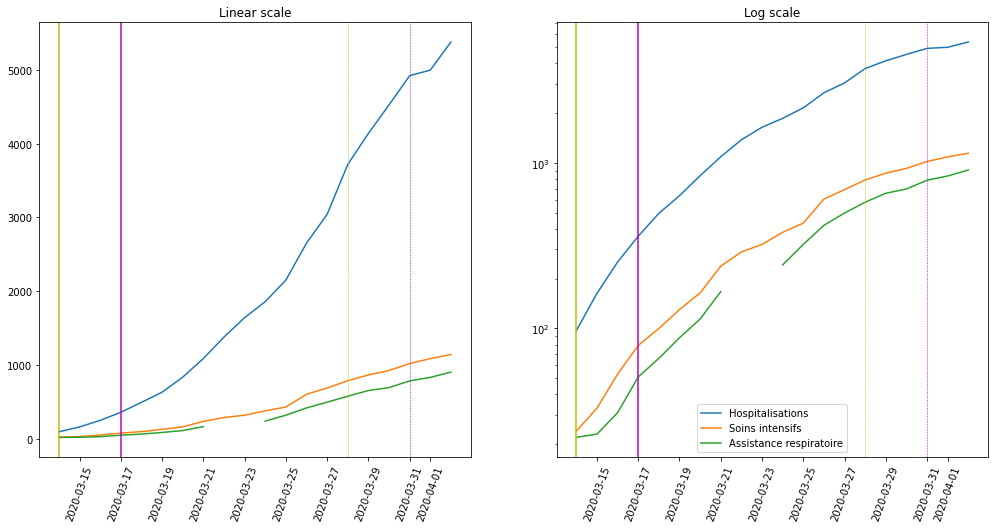

In [4]:
degrees = 70
f, (ax1, ax2) = plt.subplots(1, 2)
ax2.set_yscale('log')
ax1.set_title('Linear scale')
ax2.set_title('Log scale')

for ax in (ax1, ax2):
    ax.plot(df.index, df.hospit, label="Hospitalisations")
    ax.plot(df.index, df.intensif, label="Soins intensifs")
    ax.plot(df.index, df.respi, label="Assistance respiratoire")
    for t, c in zip(gvt_measures, 'ym'):
        ax.axvline(t, c=c)
        ax.axvline(t + pd.Timedelta('14d'), c=c, ls='--', lw=.5)
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=degrees)
plt.legend();

## Linear regression on the log(data), aka exponential regression

In [5]:
N = 4

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(df.day[-N:], np.log(df.hospit[-N:]))
hospit_pred = np.exp(intercept + slope* df.day)

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(df.day[-N:], np.log(df.intensif[-N:]))
intensif_pred = np.exp(intercept + slope* df.day)

(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(df.dropna().day[-N:], np.log(df.dropna().respi[-N:]))
respi_pred = np.exp(intercept + slope* df.day)

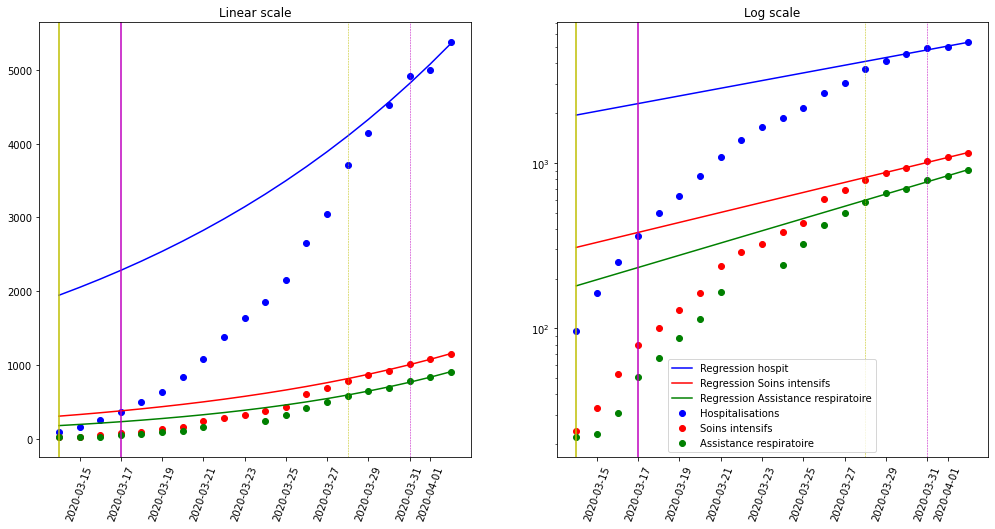

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax2.set_yscale('log')
ax1.set_title('Linear scale')
ax2.set_title('Log scale')

for ax in (ax1, ax2):
    ax.scatter(df.index, df.hospit, label="Hospitalisations", marker="o", color="b")
    ax.plot(df.index, hospit_pred, label="Regression hospit", color="b")

    ax.scatter(df.index, df.intensif, label="Soins intensifs", marker="o", color="r")
    ax.plot(df.index, intensif_pred, label="Regression Soins intensifs", color="r")

    ax.scatter(df.index, df.respi, label="Assistance respiratoire", marker="o", color="g")
    ax.plot(df.index, respi_pred, label="Regression Assistance respiratoire", color="g")

    for t, c in zip(gvt_measures, 'ym'):
        ax.axvline(t, c=c)
        ax.axvline(t + pd.Timedelta('14d'), c=c, ls='--', lw=.5)
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=degrees)

plt.legend();

## Compute the regression on data on a rolling window

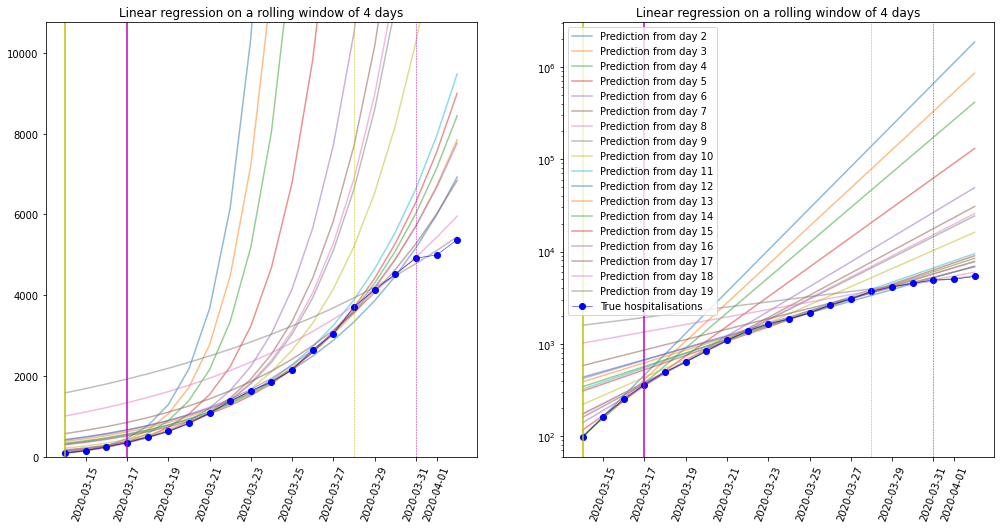

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax2.set_yscale('log')

for ax in (ax1, ax2):
    for i in range(2, len(df.day)):
        start = max(0, i-N)
        (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(df.day[start:i], np.log(df.hospit[start:i]))
        hospit_pred = np.exp(intercept + slope* df.day)
        ax.plot(df.index, hospit_pred, label=f"Prediction from day {i}", alpha=0.5)


    ax.plot(df.index, df.hospit, label="True hospitalisations", marker="o", color="b", lw=.5)

    for t, c in zip(gvt_measures, 'ym'):
        ax.axvline(t, c=c)
        ax.axvline(t + pd.Timedelta('14d'), c=c, ls='--', lw=.5)
    ax.set_title(f"Linear regression on a rolling window of {N} days");
    
    matplotlib.pyplot.sca(ax)
    plt.xticks(rotation=degrees)

ax1.set_ylim(0, df.hospit.max() * 2)

plt.legend();

In [8]:
reg = pd.DataFrame(
    [
        stats.linregress(df.day[max(0, i-N):i], np.log(df.hospit[max(0, i-N):i]))
        for i in range(2, len(df.day))
    ],
    columns= ['slope', 'intercept', "rvalue", "pvalue", "stderr"]
)
reg['slopediff'] = reg.slope.diff()

In [9]:
reg

,slope,intercept,rvalue,pvalue,stderr,slopediff
0,0.519039,4.055672,1.000000,0.000000,0.000000,NaN
1,0.477359,4.111245,0.998732,0.032065,0.024064,-0.041680
2,0.437818,4.177147,0.996693,0.003307,0.025238,-0.039541
3,0.369793,4.385384,0.997422,0.002578,0.018813,-0.068025
4,0.308556,4.630732,0.996558,0.003442,0.018150,-0.061237
5,0.276831,4.796760,0.998769,0.001231,0.009720,-0.031725
6,0.263709,4.881256,0.999729,0.000271,0.004340,-0.013122
7,0.259656,4.903761,0.999368,0.000632,0.006528,-0.004053
8,0.226019,5.168079,0.996042,0.003958,0.014262,-0.033637
9,0.177878,5.598894,0.989987,0.010013,0.017934,-0.048141


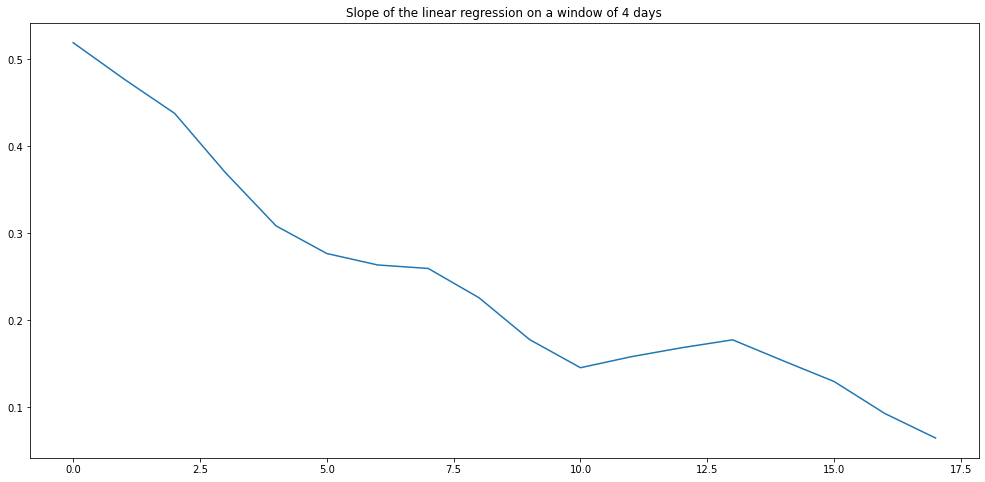

In [10]:
reg.slope.plot()
plt.title(f"Slope of the linear regression on a window of {N} days");